In [1]:
import numpy as np
import torch
from cellpose import resnet_torch
from cellpose import transforms, dynamics
import cv2
import time
from unet_architecture import UNet
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchmetrics.classification import BinaryJaccardIndex
import torchvision
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
from cellpose import utils
import logging
from cellpose import models
core_logger = logging.getLogger(__name__)
tqdm_out = utils.TqdmToLogger(core_logger, level=logging.INFO)

In [407]:
from cellpose import utils
from tqdm import trange, tqdm
import logging

core_logger = logging.getLogger(__name__)
tqdm_out = utils.TqdmToLogger(core_logger, level=logging.INFO)

def pred(x, network, return_conv=False, return_training_data=False,channels=None):
    """ convert imgs to torch and run network model and return numpy """
    #X = x.to('cuda:0')
    X = x
    #self.net.eval()
    with torch.no_grad():
        if return_training_data == False:
            if channels == 1:
                X = X[:, 0, :, :]
                X = X.unsqueeze(1)
                #X = X.to('cuda:0')
                y, style = network(X)
            else:
                #X = X.to('cuda:0')
                y, style = network(X)
        else:
            channel_32_output, final_output = network(X, training_data=True)
            return channel_32_output, final_output
    del X
    y = y.to('cuda:0')
    style = style.to('cuda:0')
    if return_conv:
        conv = conv.to('cuda:0')
        y = np.concatenate((y, conv), axis=1)
   
    return y, style
           

def run_tiled(imgi, network, augment=False, bsize=224, tile_overlap=0.1, return_conv=False, return_training_data=False,channels=None):
        """ run network in tiles of size [bsize x bsize]

        First image is split into overlapping tiles of size [bsize x bsize].
        If augment, tiles have 50% overlap and are flipped at overlaps.
        The average of the network output over tiles is returned.

        Parameters
        --------------

        imgi: array [nchan x Ly x Lx] or [Lz x nchan x Ly x Lx]

        augment: bool (optional, default False)
            tiles image with overlapping tiles and flips overlapped regions to augment

        bsize: int (optional, default 224)
            size of tiles to use in pixels [bsize x bsize]
         
        tile_overlap: float (optional, default 0.1)
            fraction of overlap of tiles when computing flows

        Returns
        ------------------

        yf: array [3 x Ly x Lx] or [Lz x 3 x Ly x Lx]
            yf is averaged over tiles
            yf[0] is Y flow; yf[1] is X flow; yf[2] is cell probability

        styles: array [64]
            1D array summarizing the style of the image, averaged over tiles

        """
        if not return_training_data:
            if imgi.ndim==4:
                batch_size = 8
                Lz, nchan = imgi.shape[:2]
                IMG, ysub, xsub, Ly, Lx = transforms.make_tiles(imgi[0], bsize=bsize,
                                                                augment=augment, tile_overlap=tile_overlap)
                ny, nx, nchan, ly, lx = IMG.shape
                batch_size *= max(4, (bsize**2 // (ly*lx))**0.5)
                yf = np.zeros((Lz, network.nout, imgi.shape[-2], imgi.shape[-1]), np.float32)
                styles = []
                if ny*nx > batch_size:
                    ziterator = trange(Lz, file=tqdm_out)
                    for i in ziterator:
                        yfi, stylei = run_tiled(imgi[i], augment=augment,
                                                    bsize=bsize, tile_overlap=tile_overlap)
                        yf[i] = yfi
                        styles.append(stylei)
                else:
                    # run multiple slices at the same time
                    ntiles = ny*nx
                    nimgs = max(2, int(np.round(batch_size / ntiles)))
                    niter = int(np.ceil(Lz/nimgs))
                    ziterator = trange(niter, file=tqdm_out)
                    for k in ziterator:
                        IMGa = np.zeros((ntiles*nimgs, nchan, ly, lx), np.float32)
                        for i in range(min(Lz-k*nimgs, nimgs)):
                            IMG, ysub, xsub, Ly, Lx = transforms.make_tiles(imgi[k*nimgs+i], bsize=bsize,
                                                                            augment=augment, tile_overlap=tile_overlap)
                            IMGa[i*ntiles:(i+1)*ntiles] = np.reshape(IMG, (ny*nx, nchan, ly, lx))
                        ya, stylea = pred(IMGa, network, channels=channels)
                        for i in range(min(Lz-k*nimgs, nimgs)):
                            y = ya[i*ntiles:(i+1)*ntiles]
                            if augment:
                                y = np.reshape(y, (ny, nx, 3, ly, lx))
                                y = transforms.unaugment_tiles(y, network)
                                y = np.reshape(y, (-1, 3, ly, lx))
                            yfi = transforms.average_tiles(y, ysub, xsub, Ly, Lx)
                            yfi = yfi[:,:imgi.shape[2],:imgi.shape[3]]
                            yf[k*nimgs+i] = yfi
                            stylei = stylea[i*ntiles:(i+1)*ntiles].sum(axis=0)
                            stylei /= (stylei**2).sum()**0.5
                            styles.append(stylei)
                return yf, np.array(styles)
            else:
                IMG, ysub, xsub, Ly, Lx = transforms.make_tiles(imgi, bsize=bsize,
                                                                augment=augment, tile_overlap=tile_overlap)
   
                ny, nx, nchan, ly, lx = IMG.shape
                IMG = np.reshape(IMG, (ny*nx, nchan, ly, lx))
                batch_size = 8
                niter = int(np.ceil(IMG.shape[0] / batch_size))
                nout = network.nout + 32*return_conv
                y = np.zeros((IMG.shape[0], nout, ly, lx))
                for k in range(niter):
                    irange = slice(batch_size*k, min(IMG.shape[0], batch_size*k+batch_size))
                    input_img = torch.from_numpy(IMG[irange])
                    y32, y0 = pred(input_img, network, return_training_data=False,channels=channels)
                    y0 = y0.cpu().detach().numpy()
                    y[irange] = y0.reshape(irange.stop-irange.start, y0.shape[-3], y0.shape[-2], y0.shape[-1])
                if augment:
                    y = np.reshape(y, (ny, nx, nout, bsize, bsize))
                    y = transforms.unaugment_tiles(y, network)
                    y = np.reshape(y, (-1, nout, bsize, bsize))
               
                yf = transforms.average_tiles(y, ysub, xsub, Ly, Lx)
                yf = yf[:,:imgi.shape[1],:imgi.shape[2]]
                return yf, y32
        else:
            tiles = []
            channel_32_outputs = []
            final_outputs = []
            IMG, ysub, xsub, Ly, Lx = transforms.make_tiles(imgi, bsize=bsize,
                                                            augment=augment, tile_overlap=tile_overlap)

            ny, nx, nchan, ly, lx = IMG.shape
            IMG = np.reshape(IMG, (ny*nx, nchan, ly, lx))
            batch_size = 8
            niter = int(np.ceil(IMG.shape[0] / batch_size))
            nout = network.nout + 32*return_conv
            y = np.zeros((IMG.shape[0], nout, ly, lx))
            for k in range(niter):
                irange = slice(batch_size*k, min(IMG.shape[0], batch_size*k+batch_size))
                input_img = torch.from_numpy(IMG[irange])

                channel_32_output, final_output = pred(input_img, network, return_training_data=True)

                tiles.append(input_img)
                channel_32_outputs.append(channel_32_output)
                final_outputs.append(final_output)

            return tiles, channel_32_outputs, final_outputs


def run_net(imgs, network, augment=False, tile=True, tile_overlap=0.1, bsize=224,
                 return_conv=False,return_training_data=False,channels=None):
        """ run network on image or stack of images

        (faster if augment is False)

        Parameters
        --------------

        imgs: array [Ly x Lx x nchan] or [Lz x Ly x Lx x nchan]

        rsz: float (optional, default 1.0)
            resize coefficient(s) for image

        augment: bool (optional, default False)
            tiles image with overlapping tiles and flips overlapped regions to augment

        tile: bool (optional, default True)
            tiles image to ensure GPU/CPU memory usage limited (recommended);
            cannot be turned off for 3D segmentation

        tile_overlap: float (optional, default 0.1)
            fraction of overlap of tiles when computing flows

        bsize: int (optional, default 224)
            size of tiles to use in pixels [bsize x bsize]

        Returns
        ------------------

        y: array [Ly x Lx x 3] or [Lz x Ly x Lx x 3]
            y[...,0] is Y flow; y[...,1] is X flow; y[...,2] is cell probability

        style: array [64]
            1D array summarizing the style of the image,
            if tiled it is averaged over tiles

        """  
        if imgs.ndim==4:  
            # make image Lz x nchan x Ly x Lx for net
            imgs = np.transpose(imgs, (0,3,1,2))
            detranspose = (0,2,3,1)
            return_conv = False
        else:
            # make image nchan x Ly x Lx for net
            imgs = np.transpose(imgs, (2,0,1))
            detranspose = (1,2,0)

        # pad image for net so Ly and Lx are divisible by 4
        imgs, ysub, xsub = transforms.pad_image_ND(imgs)
        # slices from padding
#         slc = [slice(0, self.nclasses) for n in range(imgs.ndim)] # changed from imgs.shape[n]+1 for first slice size
        slc = [slice(0, imgs.shape[n]+1) for n in range(imgs.ndim)]
        slc[-3] = slice(0, network.nout + 32*return_conv + 1)
        slc[-2] = slice(ysub[0], ysub[-1]+1)
        slc[-1] = slice(xsub[0], xsub[-1]+1)
        slc = tuple(slc)

        # run network
        if not return_training_data:
            if tile or augment or imgs.ndim==4:
                y, style = run_tiled(imgs, network=network, augment=augment, bsize=bsize,
                                        tile_overlap=tile_overlap,
                                        return_conv=return_conv,channels=channels)
            else:
                imgs = np.expand_dims(imgs, axis=0)
                y, style = network(imgs)
                y, style = y[0], style[0]
            style /= (style**2).sum()**0.5

            # slice out padding
            y = y[slc]
            # transpose so channels axis is last again
            y = np.transpose(y, detranspose)
           
            return y, style
        else:
            tiles, channel_32_outputs, final_outputs = run_tiled(imgs, network=network, augment=augment, bsize=bsize,
                                        tile_overlap=tile_overlap,
                                        return_conv=return_conv, return_training_data=return_training_data)
            return tiles, channel_32_outputs, final_outputs

def run_cp(x, network, compute_masks=True, normalize=True, invert=False,
            rescale=1.0, net_avg=False, resample=True,
            augment=False, tile=True, tile_overlap=0.1,
            cellprob_threshold=0.0,
            flow_threshold=0.4, min_size=15,
            interp=True, anisotropy=1.0, do_3D=False, stitch_threshold=0.0,
            return_training_data=False,channels=None):
   
    tic = time.time()
    shape = x.shape
    print('shape:',shape)
    nimg = shape[0]        
   
    bd, tr = None, None
    #tqdm_out = utils.TqdmToLogger(models_logger, level=logging.INFO)
    #iterator = trange(nimg,file=tqdm_out) if nimg>1 else range(nimg)
    iterator = range(nimg)
    styles = np.zeros((nimg, network.nbase[-1]), np.float32)
    if resample:
        dP = np.zeros((2, nimg, shape[1], shape[2]), np.float32)
        cellprob = np.zeros((nimg, shape[1], shape[2]), np.float32)
       
    else:
        dP = np.zeros((2, nimg, int(shape[1]*rescale), int(shape[2]*rescale)), np.float32)
        cellprob = np.zeros((nimg, int(shape[1]*rescale), int(shape[2]*rescale)), np.float32)

    if not return_training_data:
        for i in iterator:
            img = np.asarray(x[i])
            if normalize or invert:
                img = transforms.normalize_img(img, invert=invert)
            if rescale != 1.0:
                img = transforms.resize_image(img, rsz=rescale)
            #yf, style = self._run_nets(img, net_avg=net_avg,
            #                            augment=augment, tile=tile,
            #                            tile_overlap=tile_overlap)

            yf, style = run_net(img, network=network, augment=augment, tile=tile, tile_overlap=0.1, bsize=224,
                    return_conv=False,channels=channels)
            if resample:
                yf = transforms.resize_image(yf, shape[1], shape[2])

            cellprob[i] = yf[:,:,2]
            dP[:, i] = yf[:,:,:2].transpose((2,0,1))
            if network.nout == 4:
                if i==0:
                    bd = np.zeros_like(cellprob)
                bd[i] = yf[:,:,3]
        del yf, style
       
       
        net_time = time.time() - tic

        if compute_masks:
            tic=time.time()
            niter = 200 if (do_3D and not resample) else (1 / rescale * 200)
            masks, p = [], []
            resize = [shape[1], shape[2]] if not resample else None
            use_gpu = torch.cuda.is_available()
            device = torch.device('cuda' if use_gpu else 'cpu')
            for i in iterator:
                outputs = dynamics.compute_masks(dP[:,i], cellprob[i], niter=niter, cellprob_threshold=cellprob_threshold,
                                                        flow_threshold=flow_threshold, interp=interp, resize=resize,
                                                        use_gpu=use_gpu, device=device)
                masks.append(outputs[0])
                p.append(outputs[1])
               
            masks = np.array(masks)
            p = np.array(p)
           
            if stitch_threshold > 0 and nimg > 1:
                masks = utils.stitch3D(masks, stitch_threshold=stitch_threshold)
                masks = utils.fill_holes_and_remove_small_masks(masks, min_size=min_size)
       
            flow_time = time.time() - tic
            masks, dP, cellprob, p = masks.squeeze(), dP.squeeze(), cellprob.squeeze(), p.squeeze()
           
        else:
            masks, p = np.zeros(0), np.zeros(0)  #pass back zeros if not compute_masks
        return masks, styles, dP, cellprob, p
    else:
        tiled_images_input = []
        intermdiate_outputs = []
        flows_and_cellprob_output = []
        for i in iterator:
            img = np.asarray(x[i])
            if normalize or invert:
                img = transforms.normalize_img(img, invert=invert)
            if rescale != 1.0:
                img = transforms.resize_image(img, rsz=rescale)
            #yf, style = self._run_nets(img, net_avg=net_avg,
            #                            augment=augment, tile=tile,
            #                            tile_overlap=tile_overlap)

            #need to return tiles, 32_channel output and flow with cellprob
            tiles, channel_32_outputs, final_outputs = run_net(img, network=network, augment=augment, tile=tile, tile_overlap=0.1, bsize=224,
                    return_conv=False, return_training_data=True)
            tiled_images_input.append(tiles)
            intermdiate_outputs.append(channel_32_outputs)
            flows_and_cellprob_output.append(final_outputs)
        return tiled_images_input, intermdiate_outputs, flows_and_cellprob_output


In [361]:
def get_cp_data_deconstructed(cpnet, combined_images,rescale):
    x = np.array([combined_images])
    print('sssss',x.shape)

    if x.ndim < 4:
        x = x[np.newaxis,...]
    x = x.transpose((0,2,3,1))
    tiled_images_input, intermdiate_outputs, flows_and_cellprob_output = run_cp(x,cpnet,rescale=rescale,return_training_data=True)

    return tiled_images_input, intermdiate_outputs, flows_and_cellprob_output

def get_clean_train_data(tiled_images_input, intermdiate_outputs, flows_and_cellprob_output):
    tiled_images_input_train = tiled_images_input.copy()
    tiled_images_input_train_clean = []

    for i in range(len(tiled_images_input_train[0])):
        # Remove the channel at dimension 1
        #tiles = np.delete(tiled_images_input_train[0][i], 1, 1)
       
        tiles = np.squeeze(tiled_images_input_train[0][i])
        
        for tile in tiles:
            tiled_images_input_train_clean.append(tile)
    tiled_images_input_train_clean = torch.cat(tiled_images_input_train_clean)
    tiled_images_input_train_clean = tiled_images_input_train_clean.reshape(-1, 2, 224, 224)

    tiled_intermediate_outputs_train = intermdiate_outputs.copy()
    tiled_intermediate_outputs_train_clean = []

   
    for i in range(len(tiled_intermediate_outputs_train[0])):
        #tiles = np.delete(tiled_intermediate_outputs_train[0][i], 1, 1)
        tiles = np.squeeze(tiled_intermediate_outputs_train[0][i])
        
        for tile in tiles:
            tiled_intermediate_outputs_train_clean.append(tile)

    tiled_intermediate_outputs_train_clean = torch.stack(tiled_intermediate_outputs_train_clean)

    tiled_flows_and_cellprob_output_train = flows_and_cellprob_output.copy()
    tiled_flows_and_cellprob_output_train_clean = []

    for i in range(len(tiled_flows_and_cellprob_output_train[0])):
        #tiles = np.delete(tiled_intermediate_outputs_train[0][i], 1, 1)
        tiles = np.squeeze(tiled_flows_and_cellprob_output_train[0][i])
        
        for tile in tiles:
            tiled_flows_and_cellprob_output_train_clean.append(tile)

    tiled_flows_and_cellprob_output_train_clean = torch.stack(tiled_flows_and_cellprob_output_train_clean)

    return tiled_images_input_train_clean, tiled_intermediate_outputs_train_clean, tiled_flows_and_cellprob_output_train_clean


def get_data_cp_clean(unet,combined_images,rescale):
    tiled_images_final = []
    intermediate_outputs_final = []
    flows_and_cellprob_output_final = []

    for i in range(len(combined_images)):
        tiled_images_input, intermdiate_outputs, flows_and_cellprob_output = get_cp_data_deconstructed(unet, combined_images[i],rescale)
        print(len(tiled_images_input[0]))
        tiled_images_input_train_clean, tiled_intermediate_outputs_train_clean, tiled_flows_and_cellprob_output_train_clean = get_clean_train_data(tiled_images_input, intermdiate_outputs, flows_and_cellprob_output)
        print(tiled_images_input_train_clean.shape)
        tiled_images_final.append(tiled_images_input_train_clean)
        intermediate_outputs_final.append(tiled_intermediate_outputs_train_clean)
        flows_and_cellprob_output_final.append(tiled_flows_and_cellprob_output_train_clean)
    
    tiled_images_final = torch.cat(tiled_images_final, dim=0)
    intermediate_outputs_final = torch.cat(intermediate_outputs_final, dim=0)
    flows_and_cellprob_output_final =  torch.cat(flows_and_cellprob_output_final, dim=0)

    return tiled_images_final, intermediate_outputs_final, flows_and_cellprob_output_final

In [4]:
#getting the cellpose model we are distilling

cellpose_model_directory = "/Users/rz200/Documents/development/distillCellSegTrack/pipeline/CellPose_models/U2OS_Tub_Hoechst"

#Whole cellpose model
segmentation_model = models.CellposeModel(gpu=True, model_type=cellpose_model_directory)
n_channels = [[1, 1]]
rescale = segmentation_model.diam_mean / segmentation_model.diam_labels

#Only the architecture, easier to extract the data
cpnet = resnet_torch.CPnet(nbase=[2,32,64,128,256],nout=3,sz=3,residual_on=True)
cpnet.load_model(cellpose_model_directory)

In [5]:
#getting the images

image_folder = 'saved_cell_images_1237'
combined_images = []

for filename in os.listdir(image_folder):
    if filename.endswith('.npy'):
        image_path = os.path.join(image_folder,filename)
        numpy_image = np.load(image_path)
        combined_images.append(numpy_image)

In [6]:
#running the cellpose model on the images

x = combined_images[:2]
masks, styles, dP, cellprob, p = run_cp(x,cpnet,rescale=rescale)

In [183]:
from resnet_archi import CPnet

#unet = UNet(encChannels=(2,32,64,128,256),decChannels=(256,128,64,32),nbClasses=3) #it's not a problem to train it with 2 channels as anyway it is just the same channel repeated twice for the nuclei model but that may make more parameters to train so we may want to chang ethat
#unet = unet.to('cuda:0')
unet = CPnet(nbase=[2,32,64,128,256], nout=3, sz=3,
                residual_on=True, style_on=True, 
                concatenation=False, mkldnn=False)
unet.load_model(cellpose_model_directory)
#unet = unet.to('cuda:0')

In [10]:
#make an import model function and make predictions with it
#later on we can do a "make and train a model function" where you can give it the model you want to distill, some images and the number of channels you want it to have maximum
def import_student_model(directory, n_base=[1,32],device=None):

    #if nuclei, the n_base should start with 1
    #if cell, the n_base should start with 2
    model = CPnet(nbase=n_base, nout=3, sz=3,
                residual_on=True, style_on=True, 
                concatenation=False, mkldnn=False)

    if device is not None:
        model = model.to(device)

    model.load_model(directory)

    return model

model = import_student_model('C:/Users/rz200/Documents/development/distillCellSegTrack/pipeline/resnet_nuc_13')

#then we can mov eall to to py fiole and then into the omero screen

RuntimeError: Error(s) in loading state_dict for CPnet:
	size mismatch for upsample.up.res_up_0.conv.conv_0.0.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for upsample.up.res_up_0.conv.conv_0.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for upsample.up.res_up_0.conv.conv_0.0.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for upsample.up.res_up_0.conv.conv_0.0.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for upsample.up.res_up_0.conv.conv_0.2.weight: copying a param with shape torch.Size([32, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 32, 3, 3]).
	size mismatch for upsample.up.res_up_0.conv.conv_1.full.weight: copying a param with shape torch.Size([32, 64]) from checkpoint, the shape in current model is torch.Size([32, 32]).
	size mismatch for upsample.up.res_up_0.conv.conv_2.full.weight: copying a param with shape torch.Size([32, 64]) from checkpoint, the shape in current model is torch.Size([32, 32]).
	size mismatch for upsample.up.res_up_0.conv.conv_3.full.weight: copying a param with shape torch.Size([32, 64]) from checkpoint, the shape in current model is torch.Size([32, 32]).
	size mismatch for upsample.up.res_up_0.proj.0.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for upsample.up.res_up_0.proj.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for upsample.up.res_up_0.proj.0.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for upsample.up.res_up_0.proj.0.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for upsample.up.res_up_0.proj.1.weight: copying a param with shape torch.Size([32, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 32, 1, 1]).

In [276]:
def get_cellpose_data(cpnet, combined_images):
    images_tiled = []
    ys = []
    all_upsamples = []

    for i in range(len(combined_images)):
        print(i)
        image_t = combined_images[i]


        if len(image_t.shape) == 2:
            image_t = [image_t,image_t]
            image_t = np.array(image_t)
        
        image_t = transforms.normalize_img(image_t)

        IMG, ysub, xsub, Ly, Lx = transforms.make_tiles(image_t, bsize=224, 
                                                        augment=True, tile_overlap=0.1)
        ny, nx, nchan, ly, lx = IMG.shape
        IMG = np.reshape(IMG, (ny*nx, nchan, ly, lx))
        images_tiled.append(IMG)
        batch_size = 1
        niter = int(np.ceil(IMG.shape[0] / batch_size))
        nout = 3 + 32*False
        y = np.zeros((IMG.shape[0], nout, ly, lx))
        styles = []

        upsamples = []

        for k in range(niter):
            irange = np.arange(batch_size*k, min(IMG.shape[0], batch_size*k+batch_size))
            upsample, y0 = get_pre_activations(IMG[irange], cpnet)
            upsamples.append(upsample)
            y[irange] = y0.reshape(len(irange), y0.shape[-3], y0.shape[-2], y0.shape[-1])

        ys.append(y)

        upsamples = np.array(upsamples)
        all_upsamples.append(upsamples)

    images_tiled_np = np.array(images_tiled)
    ys_np = np.array(ys)
    all_upsamples_np = np.array(all_upsamples)

    images_tiled_np = images_tiled_np.reshape(images_tiled_np.shape[0]*images_tiled_np.shape[1], images_tiled_np.shape[2], images_tiled_np.shape[3], images_tiled_np.shape[4])
    ys_np = ys_np.reshape(ys_np.shape[0]*ys_np.shape[1], ys_np.shape[2], ys_np.shape[3], ys_np.shape[4])
    all_upsamples_np = all_upsamples_np.reshape(all_upsamples_np.shape[0]*all_upsamples_np.shape[1], all_upsamples_np.shape[2], all_upsamples_np.shape[3], all_upsamples_np.shape[4])
        
    return images_tiled_np, ys_np, all_upsamples_np

class KD_loss(torch.nn.Module):
    def __init__(self, alpha, beta):
        super(KD_loss, self).__init__()
        self.alpha = alpha
        self.beta = beta

    def forward(self, y_32_pred, y_32_true, y_3_pred, y_3_true):

        y_32_loss = torch.mean(y_32_true - y_32_pred)**2

        flow_loss = F.mse_loss(y_3_pred[:,:2], y_3_true[:,:2])
        flow_loss /= 2

        y_3_true_map = F.sigmoid(y_3_true[:,2])

        map_loss = F.binary_cross_entropy_with_logits(y_3_pred[:,2] ,y_3_true_map)
        y_3_loss = flow_loss + map_loss
        
        return y_32_loss * self.alpha, y_3_loss * self.beta

def trainEpoch(unet, train_loader, validation_loader, loss_fn, optimiser, scheduler, epoch_num, device, progress=True):
    time_start = time.time()
    
    unet.train()

    train_y_32_loss, train_map_loss, train_IoU = 0, 0, 0

    for image, upsample, cp_output in train_loader:

        if device is not None:
            (image, upsample, cp_output) = (image.to(device),upsample.to(device),cp_output.to(device)) # sending the data to the device (cpu or GPU)

        y_32_pred, pred = unet(image)
        map_pred = pred

        y_32_pred = y_32_pred.squeeze(1)
        map_pred = map_pred.squeeze(1)

        loss_32, loss_map = loss_fn(y_32_pred,  upsample, map_pred, cp_output) # calculate the loss of that prediction
        loss = loss_32 + loss_map
        train_y_32_loss += loss_32.item()
        train_map_loss += loss_map.item()
        
        loss.backward()

        optimiser.step() # update model parameters
        optimiser.zero_grad()

        #IoU score
        jaccard = BinaryJaccardIndex(threshold=0.5).to(device)
        map_pred = F.sigmoid(map_pred)
        cp_output = F.sigmoid(cp_output)
        cp_output = torch.where(cp_output > 0.5, 1.0, 0.0)
        iou = jaccard(map_pred, cp_output)
        if not torch.isnan(iou):
            train_IoU += iou.item()
        else:
            train_IoU += 0

        del image
        del upsample
        del cp_output
        torch.cuda.empty_cache()

    if scheduler is not None:
        scheduler.step()

    train_y_32_loss, train_map_loss, train_IoU = train_y_32_loss/len(train_loader), train_map_loss/len(train_loader), train_IoU/len(train_loader)


    val_y_32_loss, val_map_loss, val_IoU = 0, 0, 0
    for image, upsample, cp_output in validation_loader:
        
        #image, upsample, cp_output = image.float(), upsample.float(), cp_output.float() #cast to float32 (important for mps)

        if device is not None:
            (image, upsample, cp_output) = (image.to(device),upsample.to(device),cp_output.to(device)) # sending the data to the device (cpu or GPU)

        #image = image.unsqueeze(1)
        y_32_pred, pred = unet(image)
        #flow_pred = pred[:,1:]
        map_pred = pred

        y_32_pred = y_32_pred.squeeze(1)
        map_pred = map_pred.squeeze(1)

        loss_32, loss_map = loss_fn(y_32_pred,  upsample, map_pred, cp_output) # calculate the loss of that prediction
        #loss = loss_32 + loss_map
        val_y_32_loss += loss_32.item()
        val_map_loss += loss_map.item()

        #IoU score
        jaccard = BinaryJaccardIndex(threshold=0.5).to(device)
        map_pred = F.sigmoid(map_pred)
        cp_output = F.sigmoid(cp_output)
        cp_output = torch.where(cp_output > 0.5, 1.0, 0.0)
        iou = jaccard(map_pred, cp_output)
        if not torch.isnan(iou):
            val_IoU += iou.item()
        else:
            val_IoU += 0

        del image
        del upsample
        del cp_output
        torch.cuda.empty_cache()

    val_y_32_loss, val_map_loss, val_IoU = val_y_32_loss/len(validation_loader), val_map_loss/len(validation_loader), val_IoU/len(validation_loader)
    
    #we might add displaying later on
    if progress:
        if epoch_num is None:
            print('Train 32 loss: ', train_y_32_loss,'Train map loss', train_map_loss, 'Train IoU', train_IoU, 'Val 32 loss: ', val_y_32_loss, 'Val map loss: ', val_map_loss, 'Val IoU: ', val_IoU, 'Time: ', time.time()-time_start)
        else:
            print('Epoch: ', epoch_num, 'Train 32 loss: ', train_y_32_loss,'Train map loss', train_map_loss, 'Train IoU', train_IoU, 'Val 32 loss: ', val_y_32_loss, 'Val map loss: ', val_map_loss, 'Val IoU: ', val_IoU, 'Time: ', time.time()-time_start)
        
    torch.cuda.empty_cache()

    return unet, train_y_32_loss, train_map_loss, train_IoU, val_y_32_loss, val_map_loss, val_IoU

def train_model(images,cellpose_model_directory,n_base,num_epochs,name_of_model,device=None,progress=True,seed=None):

    cellpose_model = CPnet(nbase=[2,32,64,128,256],nout=3,sz=3,residual_on=True)
    cellpose_model.load_model(cellpose_model_directory)

    #we would ideally want to gather the data here and not have to give it
    
    #training the model
    
    torch.manual_seed(seed)
    student_model = CPnet(nbase=n_base, nout=3, sz=3,
                residual_on=True, style_on=True, 
                concatenation=False, mkldnn=False)
    
    if device is not None:
        student_model = student_model.to(device)

    loss_fn = KD_loss(alpha=2, beta=1)
    optimiser = torch.optim.Adam(student_model.parameters(), lr=0.01)
    scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=5, gamma=0.1)

    best_val_map_loss = 1000
    for epoch in range(num_epochs):
        student_model, train_y_32_loss, train_map_loss, train_IoU, val_y_32_loss, val_map_loss, val_IoU = trainEpoch(student_model, train_loader, validation_loader, loss_fn, optimiser, scheduler=scheduler, epoch_num=epoch, device=device, progress=True)
        if val_map_loss < best_val_map_loss:
            best_val_map_loss = val_map_loss
            torch.save(student_model.state_dict(), name_of_model)

    return student_model


In [338]:
print(len(combined_images))

30


In [344]:
print(combined_images[0].shape)

(2, 1080, 1080)


In [346]:
print(unet)

CPnet(
  (downsample): downsample(
    (down): Sequential(
      (res_down_0): resdown(
        (conv): Sequential(
          (conv_0): Sequential(
            (0): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU(inplace=True)
            (2): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (conv_1): Sequential(
            (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU(inplace=True)
            (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (conv_2): Sequential(
            (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU(inplace=True)
            (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (conv_3): Sequential(
            (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, tra

In [347]:
print(combined_images[0].shape)

(2, 1080, 1080)


In [363]:
tiled_images_final_1, intermediate_outputs_final, flows_and_cellprob_output_final = get_data_cp_clean(unet,[combined_images[0]],rescale=1.28)

sssss (1, 2, 1080, 1080)
8
torch.Size([64, 2, 224, 224])


In [366]:
#should keep some test images here
#I think there may be an issue with get_data_cp_clean as we are only getting 1080 images out of 30 full images
tiled_images_final, intermediate_outputs_final, flows_and_cellprob_output_final = get_data_cp_clean(unet,combined_images,rescale=1.28)

sssss (1, 2, 1080, 1080)
8
torch.Size([64, 2, 224, 224])
sssss (1, 2, 1080, 1080)
8
torch.Size([64, 2, 224, 224])
sssss (1, 2, 1080, 1080)
8
torch.Size([64, 2, 224, 224])
sssss (1, 2, 1080, 1080)
8
torch.Size([64, 2, 224, 224])
sssss (1, 2, 1080, 1080)
8
torch.Size([64, 2, 224, 224])
sssss (1, 2, 1080, 1080)
8
torch.Size([64, 2, 224, 224])
sssss (1, 2, 1080, 1080)
8
torch.Size([64, 2, 224, 224])
sssss (1, 2, 1080, 1080)
8
torch.Size([64, 2, 224, 224])
sssss (1, 2, 1080, 1080)
8
torch.Size([64, 2, 224, 224])
sssss (1, 2, 1080, 1080)
8
torch.Size([64, 2, 224, 224])
sssss (1, 2, 1080, 1080)
8
torch.Size([64, 2, 224, 224])
sssss (1, 2, 1080, 1080)
8
torch.Size([64, 2, 224, 224])
sssss (1, 2, 1080, 1080)
8
torch.Size([64, 2, 224, 224])
sssss (1, 2, 1080, 1080)
8
torch.Size([64, 2, 224, 224])
sssss (1, 2, 1080, 1080)
8
torch.Size([64, 2, 224, 224])
sssss (1, 2, 1080, 1080)
8
torch.Size([64, 2, 224, 224])
sssss (1, 2, 1080, 1080)
8
torch.Size([64, 2, 224, 224])
sssss (1, 2, 1080, 1080)
8
torc

In [80]:
class ImageDataset(Dataset):
    def __init__(self, image, upsample, cellprob):
        self.image = image
        self.upsample = upsample
        self.cellprob = cellprob

    def __len__(self):
        return len(self.image)

    def __getitem__(self, idx):
        img = self.image[idx]
        upsample = self.upsample[idx]
        cellprob = self.cellprob[idx]
        return img, upsample, cellprob

In [367]:
print(len(tiled_images_final))

1920


In [368]:
num = 1080

train_images_tiled, val_images_tiled, train__upsamples, val__upsamples, train_ys, val_ysm = train_test_split(tiled_images_final,intermediate_outputs_final, flows_and_cellprob_output_final, test_size=0.1, random_state=42)

train_dataset = ImageDataset(train_images_tiled, train__upsamples, train_ys)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

validation_dataset = ImageDataset(val_images_tiled, val__upsamples, val_ysm)
validation_loader = DataLoader(validation_dataset, batch_size=8, shuffle=True)

In [369]:
print(np.unique(train_ys[0][2]))

[-30.02802  -29.992691 -29.919857 ...   9.266088   9.271589   9.272319]


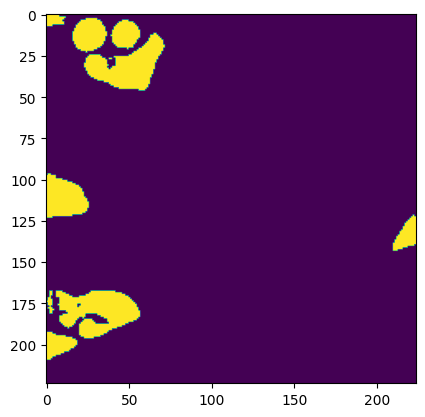

In [370]:
plt.imshow(train_ys[950][2]>7)

In [394]:
student_model = train_model(combined_images,cellpose_model_directory,[2,32,64],100,'resnet_cells_64',device='cuda:0',progress=True,seed=4)

c:\Users\rz200\AppData\Local\anaconda3\envs\cellprob\lib\site-packages\torch\nn\functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch:  0 Train 32 loss:  1.0595452034926054 Train map loss 2.3030013411685273 Train IoU 0.5371051147856094 Val 32 loss:  0.8021783716976643 Val map loss:  1.8758287305633228 Val IoU:  0.6112031117081642 Time:  40.950520038604736
Epoch:  1 Train 32 loss:  0.5772677525546307 Train map loss 1.6625447684416064 Train IoU 0.6142625699716585 Val 32 loss:  0.4079047923989189 Val map loss:  1.411873382826646 Val IoU:  0.6853042294581732 Time:  41.422985792160034
Epoch:  2 Train 32 loss:  0.4629159979361951 Train map loss 1.2981432521784748 Train IoU 0.6664553737198865 Val 32 loss:  0.1860249123904699 Val map loss:  1.2319352502624195 Val IoU:  0.5544834199051062 Time:  41.73894429206848
Epoch:  3 Train 32 loss:  0.40035653525245396 Train map loss 1.250594771846577 Train IoU 0.6546924161138358 Val 32 loss:  0.4393394105718471 Val map loss:  1.3409486040472984 Val IoU:  0.7139614050587019 Time:  41.99955940246582
Epoch:  4 Train 32 loss:  0.42975015803284683 Train map loss 1.160894110246941 Trai

KeyboardInterrupt: 

In [ ]:
#next step is to make a proper prediction function and give if its nuclei or cell

model = CPnet(nbase=[2,32,64,128], nout=3, sz=3,
                residual_on=True, style_on=True,
                concatenation=False, mkldnn=False)
model.load_model("/Users/rz200/Documents/development/distillCellSegTrack/pipeline/resnet_7", device=torch.device('cuda:0'))

def make_prediction(image, model, device, type):
    #type can be 'nuclei' or 'cell'

    if not isinstance(image, list):
        x = np.array([image])
    #if there is only one channel, copy the channel to make it 2 channels
    if x.shape[0] == 1:
        x = np.repeat(x, 2, axis=0)
    if x.ndim < 4:
        x = x[np.newaxis,...]
    x = x.transpose((0,2,3,1))

    if type == 'nuclei':
        masks, styles, dP, cellprob, p = run_cp(x,model,channels=1,rescale=1.283732,return_training_data=False)
    elif type == 'cell':
        masks, styles, dP, cellprob, p = run_cp(x,model,channels=2,rescale=1.283732,return_training_data=False)

    return masks

In [408]:
#MAKE A PREDICTION WITH A CELL MODEL

from resnet_archi import CPnet
model = CPnet(nbase=[2,32,64,128], nout=3, sz=3,
                residual_on=True, style_on=True,
                concatenation=False, mkldnn=False)
model.load_model("/Users/rz200/Documents/development/distillCellSegTrack/pipeline/resnet_7", device=torch.device('cuda:0'))

x = np.array([combined_images[0]])
#if there is only one channel, copy the channel to make it 2 channels
if x.shape[0] == 1:
    x = np.repeat(x, 2, axis=0)
if x.ndim < 4:
    x = x[np.newaxis,...]
x = x.transpose((0,2,3,1))
print(x.shape)
masks, styles, dP, cellprob, p = run_cp(x,model,channels=2,rescale=1.283732,return_training_data=False)

(2, 1080, 1080, 2)
shape: (2, 1080, 1080, 2)


In [424]:
#MAKE A PREDICTION WIHT A NUCLEI MODEL

from resnet_archi import CPnet
model = CPnet(nbase=[1,32,64,128], nout=3, sz=3,
                residual_on=True, style_on=True,
                concatenation=False, mkldnn=False)
model.load_model("/Users/rz200/Documents/development/distillCellSegTrack/pipeline/resnet_nuc_15_1", device=torch.device('cuda:0'))

x = np.array([combined_images[0][1]])
#if there is only one channel, copy the channel to make it 2 channels
if x.shape[0] == 1:
    x = np.repeat(x, 2, axis=0)
if x.ndim < 4:
    x = x[np.newaxis,...]
x = x.transpose((0,2,3,1))
print(x.shape)
masks, styles, dP, cellprob, p = run_cp(x,model,channels=1,rescale=1.283732,return_training_data=False)

(1, 1080, 1080, 2)
shape: (1, 1080, 1080, 2)


In [402]:
x = np.array([combined_images[0]])
#if there is only one channel, copy the channel to make it 2 channels
if x.shape[0] == 1:
    x = np.repeat(x, 2, axis=0)
if x.ndim < 4:
    x = x[np.newaxis,...]
x = x.transpose((0,2,3,1))
print(x.shape)
masks, styles, dP, cellprob, p = run_cp(x,student_model,channels=2,rescale=1.283732,return_training_data=False)

(2, 1080, 1080, 2)
shape: (2, 1080, 1080, 2)


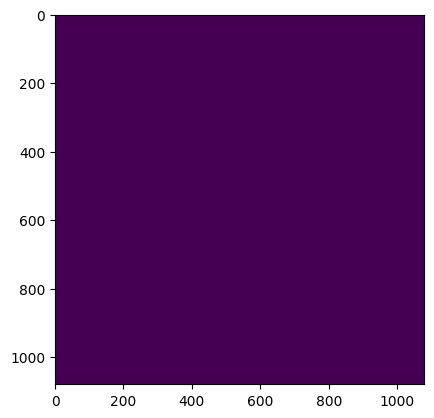

In [405]:
plt.imshow(masks[1])

In [385]:
print(combined_images[0].shape)

(2, 1080, 1080)


In [386]:
test_image = combined_images[0][:,250:526, 250:526]
test_image = torch.from_numpy(test_image.astype(np.float32)).unsqueeze(0)
test_image = test_image.to('cuda:0')
prediction_f = student_model(test_image)

In [387]:
print(np.unique(prediction_f[1][0][2].cpu().detach().numpy()))

[-7.1700587 -3.7521138 -3.719771  ... 16.229856  16.460817  16.514196 ]


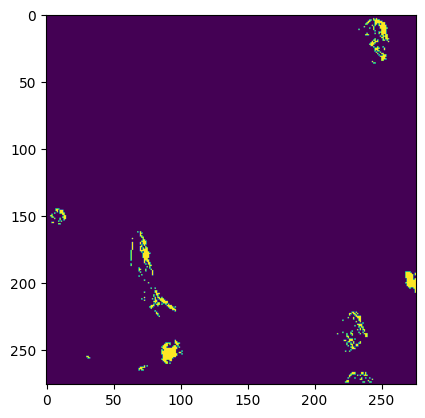

In [388]:
plt.imshow(prediction_f[1][0][2].cpu().detach().numpy()>0.5)

In [389]:
print(test_image.shape)

torch.Size([1, 2, 276, 276])


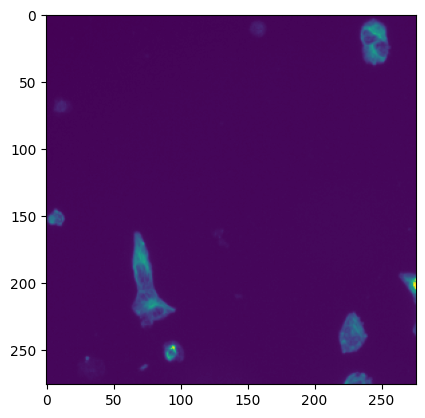

In [390]:
plt.imshow(test_image[0,0,:].cpu().detach().numpy())

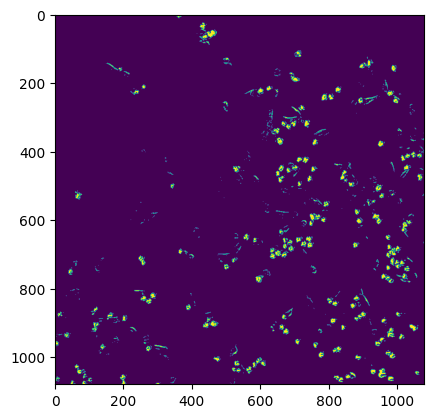

In [391]:
plt.imshow(cellprob>0.5)

In [392]:
print(test_images[0].shape)

(2, 1080, 1080)


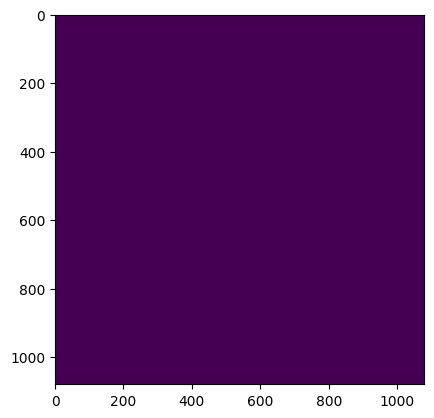

In [393]:
plt.imshow(masks)